In [1]:
using OrdinaryDiffEq, ParameterizedFunctions
using Optim, LsqFit
using Plots, LaTeXStrings
using DelimitedFiles
using Statistics

# Viral load data fitting

Data for influenza from

*Smith, A. P., Moquin, D. J., Bernhauerova, V., & Smith, A. M. (2018). Influenza virus infection model with density dependence supports biphasic viral decay. Frontiers in Microbiology, 9(JUL), 1–10. https://doi.org/10.3389/fmicb.2018.01554*


## Data set

10 mice with 13 data points each

In [249]:
tdata = Array(range(0, 12 , step=1.0))[1:10]
tend = tdata[end]
data = readdlm("../../data/Smith2018/Virus_Best10.txt", ' ', Float64, '\n')'[1:10,:]

10×10 Array{Float64,2}:
 0.0      0.0      0.0      0.0      …  0.0      0.0      0.0      0.0
 4.18551  3.99136  3.49136  3.29788     3.49136  4.00515  3.49136  4.50515
 5.67816  5.47712  5.44716  5.77233     5.7954   6.03148  6.18551  6.17215
 6.00515  5.84488  5.81012  6.24612     5.74951  5.83815  5.78784  6.03148
 5.9364   5.82436  5.83815  5.49136     6.03148  6.26036  5.59921  5.49136
 5.97712  5.81012  5.78016  5.9624   …  5.82436  6.1294   5.97712  5.34242
 5.44716  5.0874   5.2954   5.14412     5.2954   5.18551  5.34488  5.81012
 5.19848  4.49136  5.01851  5.51851     5.17215  4.83815  5.47712  5.01188
 4.00515  0.0      2.94716  3.23882     3.26036  0.0      0.0      0.0
 0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0

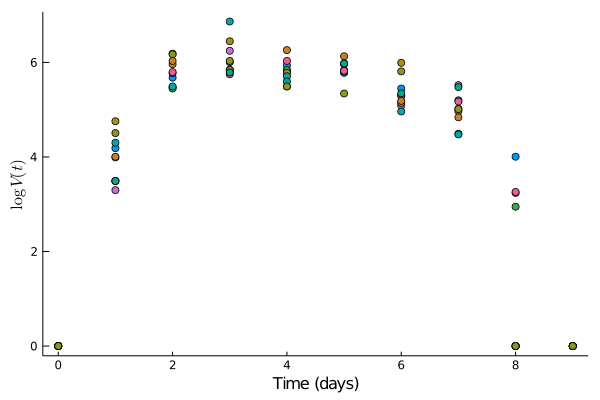

In [250]:
plt = plot(legend=:none, grid=:none, xlabel="Time (days)", ylabel=L"\log\,V(t)")
[plot!(tdata, data[:, i], seriestype=:scatter) for i in 1:size(data, 2)]
plt

### Average of data

In [251]:
vdata_avg = mean(data, dims=2)[:]
vdata_std = std(data, dims=2)[:];

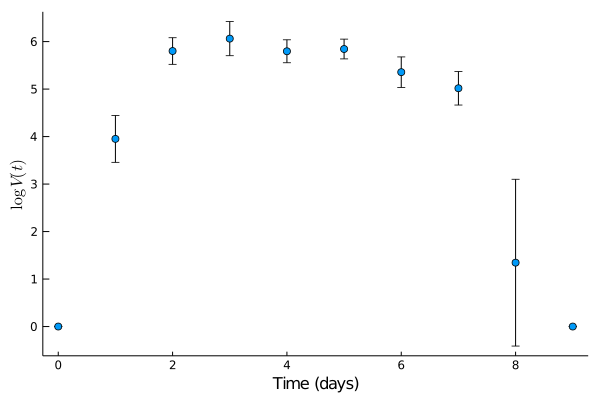

In [252]:
plot(tdata, vdata_avg, yerrors=vdata_std,
    seriestype=:scatter, legend=:none, grid=:off,
    xlabel="Time (days)", ylabel=L"\log\,V(t)")

### Combined data

In [253]:
ttdata = reshape(repeat(tdata', 10), 1, :)[:]
vvdata = reshape(data', 1, :)[:];

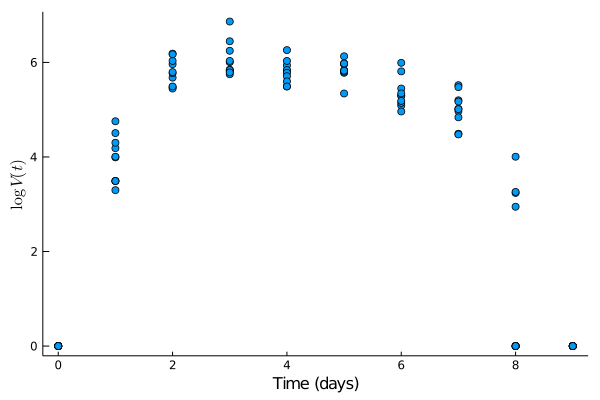

In [254]:
plot(ttdata, vvdata, 
    seriestype=:scatter, legend=:none, grid=:none,
    xlabel="Time (days)", ylabel=L"\log\,V(t)")

## ODE Model


The standard kinetic model with varying clearance rate reads
$$
\begin{aligned}
\frac{dT}{dt} & = -\beta T V, \\
\frac{dI_1}{dt} & = \beta T V - k I_1, \\
\frac{dI_2}{dt} & = k I_1 - \frac{\delta I_2}{K + I_2}, \\
\frac{dV}{dt} & = p I_2 -c V.
\end{aligned}
$$

*Smith, A. P., Moquin, D. J., Bernhauerova, V., & Smith, A. M. (2018). Influenza virus infection model with density dependence supports biphasic viral decay. Frontiers in Microbiology, 9(JUL), 1–10. https://doi.org/10.3389/fmicb.2018.01554*


In [255]:
viral_target = @ode_def begin
    dT = -β*T*V
    dI₁ = β*T*V - k*I₁
    dI₂ = k*I₁ - δ*I₂/(K + I₂)
    dV = p*I₂ - c*V
end β k δ K p c;

In [256]:
u0 = [1e+7, 75.0, 0.0, 1e0]
tspan = (0.0, tend)
pars = (β = 9.9e-5,
        k = 4.0,
        δ = 1.65e+6,
        K = 1.134e+5,
        p = 1.7,
        c = 12.48)
prob = ODEProblem(viral_target, u0, tspan, pars)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 9.0)
u0: [1.0e7, 75.0, 0.0, 1.0]

In [257]:
sol = solve(prob, Tsit5(); dtmax=1e-2);

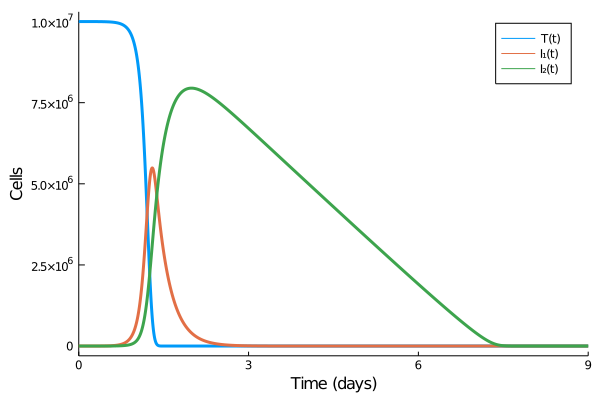

In [258]:
plot(sol, vars=(1:3), lw=3, xlabel="Time (days)", ylabel="Cells", grid=:off)

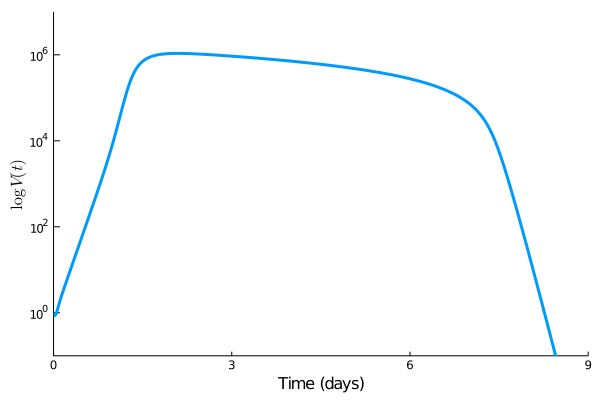

In [259]:
plot(sol, vars=(4), lw=3, legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (1e-1, 1e+7), :log10))

### Fitting the ODE model to data

Only $V$ in logarithmic scale to fit the model.

Problem: V becomes negative for large $t$. What should we do?

In [260]:
function model(t, p)
    pars = (β = p[1],
            k = p[2],
            δ = p[3],
            K = p[4],
            p = p[5],
            c = p[6])
    prob = ODEProblem(viral_target, u0, tspan, pars)
    sol = solve(prob, Rosenbrock23(), dtmax=1e-2)
    # TODO: fix negative numbers
    # log10.(max.(sol(t)[end, :], 1e-15))
    log10.(sol(t)[end, :])
end

model (generic function with 1 method)

In [261]:
par0 = [9.9e-5,
        4.0,
        1.65e+6,
        1.13e+5,
        1.7,
        12.4]
lower = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
upper = [Inf, Inf, Inf, Inf, Inf, Inf]
fit = curve_fit(model, ttdata, vvdata, par0, lower=lower, upper=upper)

DomainError: DomainError with -4.439074578217222e-5:
NaN result for non-NaN input.

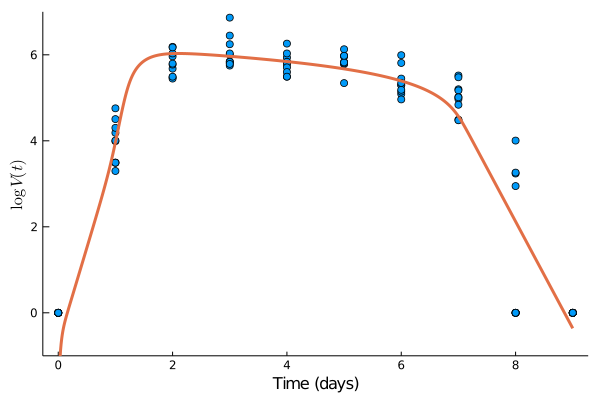

In [233]:
plot(ttdata, vvdata, seriestype=:scatter)
tt = [range(0., tend, step=1e-2);]
plot!(tt, model(tt, fit.param), lw=3, legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))

In [262]:
par0

6-element Array{Float64,1}:
      9.9e-5
      4.0
      1.65e6
 113000.0
      1.7
     12.4

In [234]:
fit.param

6-element Array{Float64,1}:
     0.00023591394112187317
     4.443049969556413
     1.687592372719871e6
 67481.5464910966
     0.7801300513849385
     5.720746834498756

In [235]:
β = p[1],
k = p[2],
δ = p[3],
K = p[4],
p = p[5],
c = p[6])
confidence_interval(fit, 0.1)

6-element Array{Tuple{Float64,Float64},1}:
 (-0.014271502297002534, 0.014743330179246282)
 (-194.07090451117466, 202.9570044502875)
 (-2.441064057225261e6, 5.816248802665004e6)
 (-4.1316588066928163e6, 4.26662189967501e6)
 (-2.117883150652008, 3.6781432534218856)
 (-2.7943003781004254, 14.235794047097938)

In [236]:
sum(abs2, fit.resid)

2005.105744102133

In [58]:
stderror(fit)

6-element Array{Float64,1}:
   0.008732958370392679
 119.49847388168565
   2.4853071102774343e6
   2.5277359726829017e6
   1.7445028277143457
   5.125761307802023

In [59]:
res(p) = sum(abs2, model(ttdata, p) - vvdata)

res (generic function with 1 method)

In [60]:
fit2 = optimize(res, fit.param, NewtonTrustRegion())

 * Status: success

 * Candidate solution
    Final objective value:     2.005106e+03

 * Found with
    Algorithm:     Newton's Method (Trust Region)

 * Convergence measures
    |x - x'|               = 1.08e-19 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.42e-26 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.36e+03 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    37
    f(x) calls:    38
    ∇f(x) calls:   38
    ∇²f(x) calls:  5


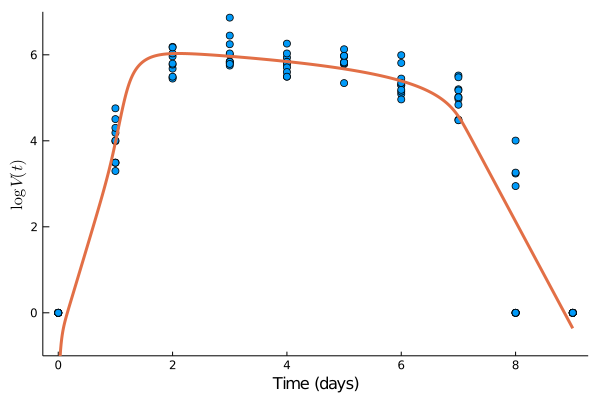

In [62]:
plot(ttdata, vvdata, seriestype=:scatter)
tt = [range(0., tend, step=1e-2);]
plot!(tt, model(tt, fit2.minimizer), lw=3, legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))

In [65]:
fit2.minimizer-fit.param

6-element Array{Float64,1}:
  2.3282837352425582e-10
  1.687538997430238e-14
  0.0
  0.0
  1.1118883591620943e-12
 -1.652011860642233e-13

## Standard viral function

Now consider a virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{\max - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - \min}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.




In [114]:
heaviside(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))
v₁(t, a₁, a₂, max) = 1. + (max - 1.0)*(tanh(6.0*(t - (a₁ + a₂)/2)/(a₂ - a₁)) - tanh(-3.0*(a₂ + a₁)/(a₂ - a₁)))/2
v₂(t, a₂, α) = 1. - heaviside(t - a₂) + heaviside(t - a₂)*exp(-α*(t - a₂))
v₃(t, b₁, b₂, min) = 1. - (1.0 - min)*(tanh(6.0*(t - (b₁ + b₂)/2)/(b₂ - b₁)) - tanh(-3.0*(b₂ + b₁)/(b₂ - b₁)))/2
function ViralLoad(t, par) 
    a₁, a₂, b₁, b₂, α, maxi = par
    mini = 1e-6
    if any(v₁.(t, a₁, a₂, maxi) .< 0) println("v1= ", v₁.(t, a₁, a₂, maxi)) end
    if any(v₂.(t, a₂, α) .< 0) println("v2= ", v₂.(t, a₂, α)) end
    if any(v₃.(t, b₁, b₂, mini) .< 0) println("v3= ", v₃.(t, b₁, b₂, mini)) end
    if any(v₁.(t, a₁, a₂, maxi).*v₂.(t, a₂, α).*v₃.(t, b₁, b₂, mini) .< 0) println("par: ", par) end
    log10.(v₁.(t, a₁, a₂, maxi).*v₂.(t, a₂, α).*v₃.(t, b₁, b₂, mini))
end
res(p) = sum(abs2, ViralLoad(ttdata, p) - vvdata)

res (generic function with 1 method)

In [115]:
par0 = [0.7, 2.8, 6.2, 7.6, 0.2,  9e+5]
lb   = [0.1, 2.0, 4.0, 7.0, 1e-2, 1e+5]
ub   = [2.0, 4.0, 7.0, 8.9, 1.0,  1e+7]
# fit = curve_fit(ViralLoad, ttdata, vvdata, par0, lower=lb, upper=ub)
fit = optimize(res, lb, ub, par0, Fminbox(ConjugateGradient()))

 * Status: success

 * Candidate solution
    Final objective value:     3.782286e+01

 * Found with
    Algorithm:     Fminbox with Conjugate Gradient

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.64e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    2
    f(x) calls:    1509
    ∇f(x) calls:   1136


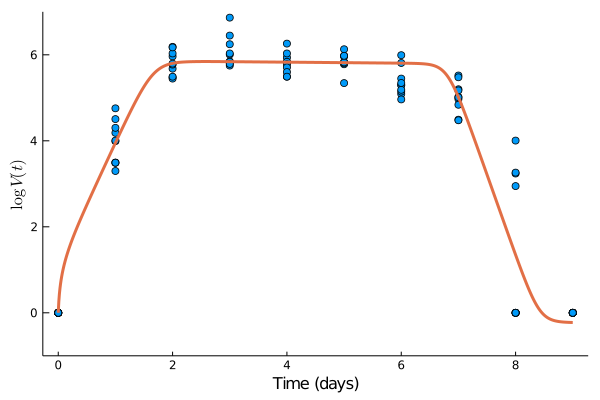

In [117]:
tt = [range(0., tend, step=1e-2);]
vv = ViralLoad(tt, fit.minimizer)
plot(ttdata, vvdata, seriestype=:scatter)
plot!(tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))

In [171]:
fit.param

7-element Array{Float64,1}:
      0.7405579049804155
      2.882552799628832
      6.226098236207015
      7.605851411822182
      0.23853437695695662
      7.194378848432214e-6
 855307.4778730464

In [172]:
stderror(fit)

7-element Array{Float64,1}:
      0.11924377520693617
      0.483045965661123
      0.1440184269803016
      0.0706358218728413
      0.12577820616216223
      3.975284980756788e-6
 208046.68071344195

https://github.com/JuliaNLSolvers/Optim.jl/blob/master/docs/src/examples/maxlikenlm.jl

In [173]:
confidence_interval(fit, 0.1)

7-element Array{Tuple{Float64,Float64},1}:
 (0.5429308562084758, 0.9381849537523552)
 (2.081983139291153, 3.683122459966511)
 (5.9874112553268715, 6.464785217087159)
 (7.4887840932968786, 7.7229187303474855)
 (0.030077577928919574, 0.44699117598499366)
 (6.059943611832488e-7, 1.378276333568118e-5)
 (510504.141641505, 1.2001108141045878e6)

In [99]:
x = -1
if (x<0) println("x= ", x) end

x= -1
